<a href="https://colab.research.google.com/github/LaFuego20/exchange-rate-forecasting/blob/main/ConvLSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data loaded successfully.
--- Calculating Performance Metrics and Preparing Plotting Data ---

Processing Full Period...
Training model on Full data...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training on Full data complete.
Evaluating model on Full test set...

Denormalized Performance Metrics for Full Test Set:
  USD_NGN: RMSE=33.4333, MAE=29.0345
  EUR_NGN: RMSE=200.6248, MAE=196.3051
  GBP_NGN: RMSE=125.5230, MAE=121.5888

Processing Pre-subsidy Period...
Training model on Pre-subsidy data...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training on Pre-subsidy data complete.
Evaluating model on Pre-subsidy test set...

Denormalized Performance Metrics for Pre-subsidy Test Set:
  USD_NGN: RMSE=16.9509, MAE=16.4012
  EUR_NGN: RMSE=22.6990, MAE=21.9108
  GBP_NGN: RMSE=7.7473, MAE=6.3276

Processing Post-subsidy Period...
Training model on Post-subsidy data...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training on Post-subsidy data complete.
Evaluating model on Post-subsidy test set...



Denormalized Performance Metrics for Post-subsidy Test Set:
  USD_NGN: RMSE=35.6594, MAE=28.5162
  EUR_NGN: RMSE=36.8112, MAE=28.1149
  GBP_NGN: RMSE=40.7283, MAE=32.7213

--- Performance Metrics Calculation and Data Preparation Complete ---

--- Generating Plots ---

Generating plots for Full Period...


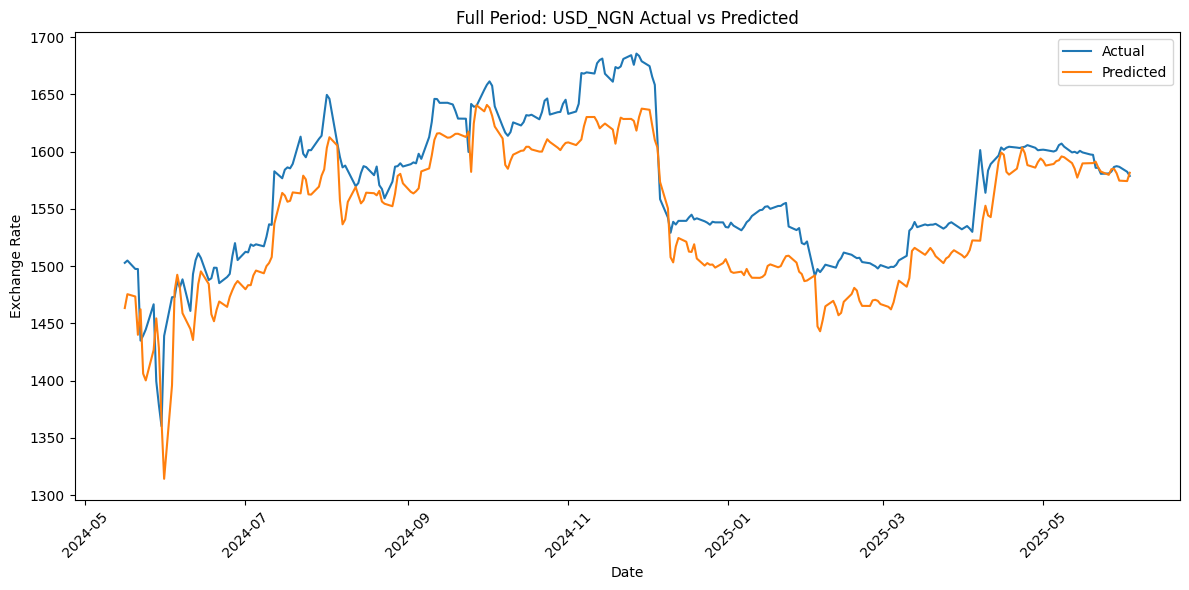

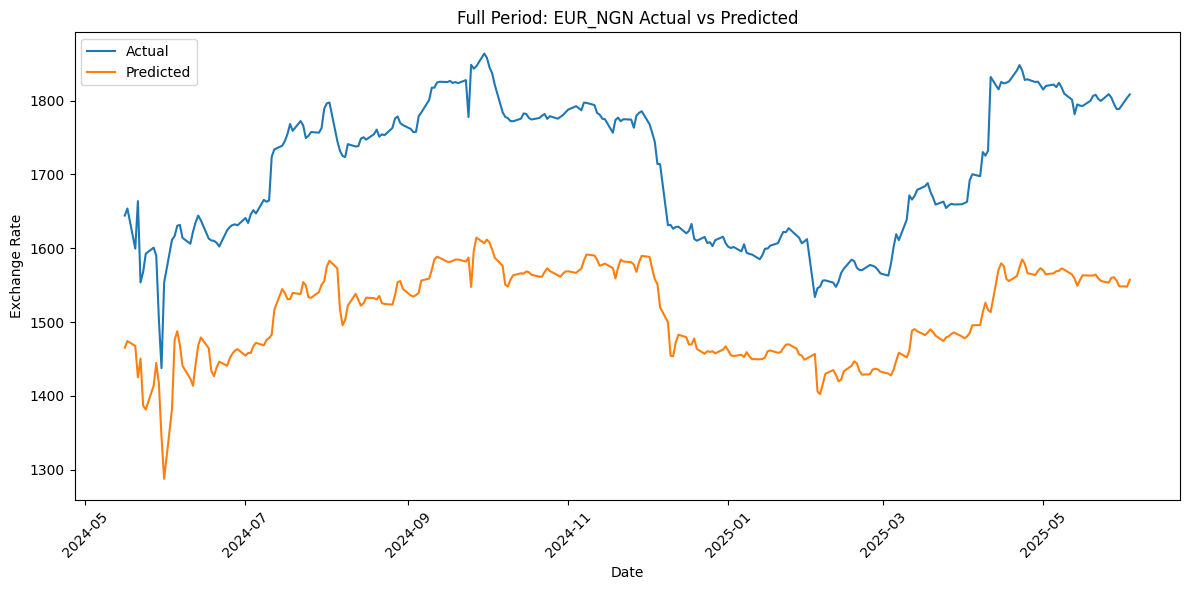

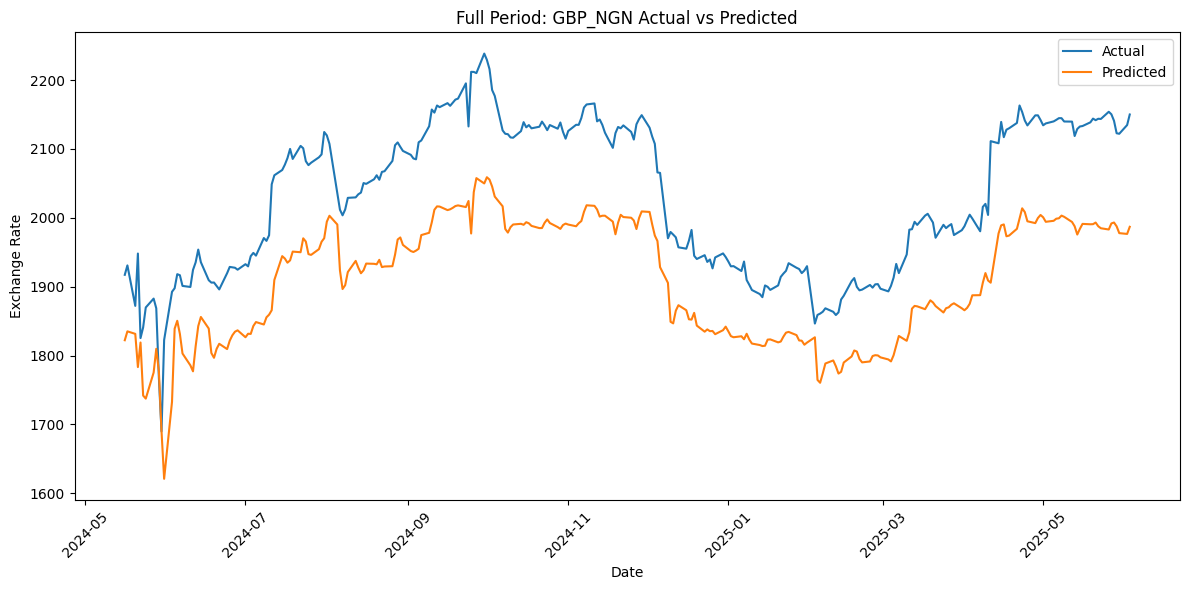


Generating plots for Pre-subsidy Period...


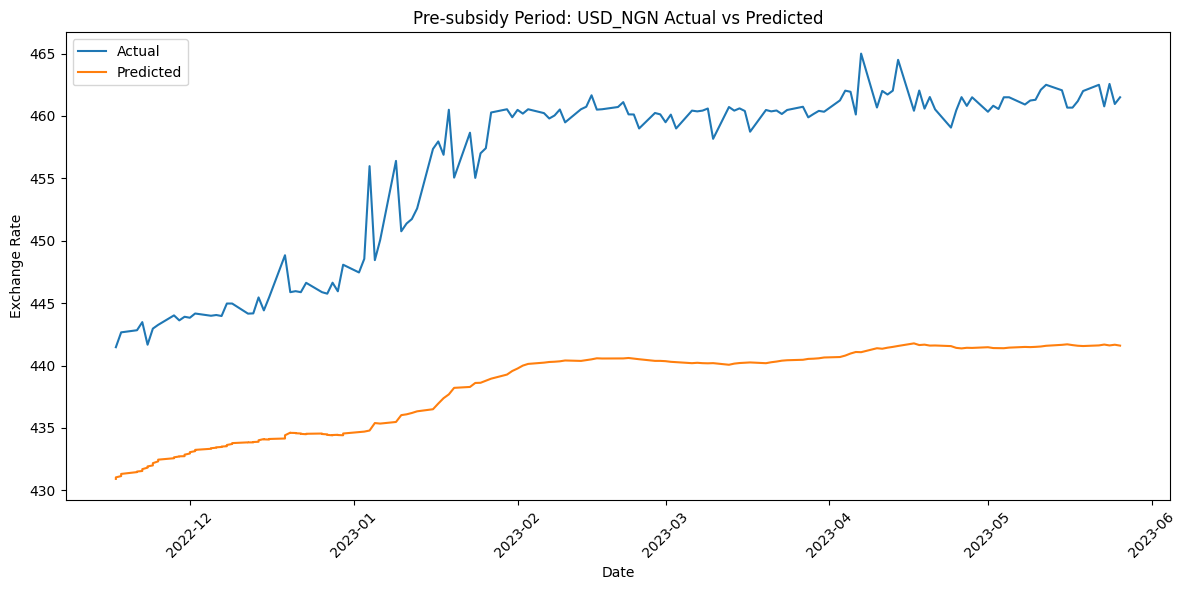

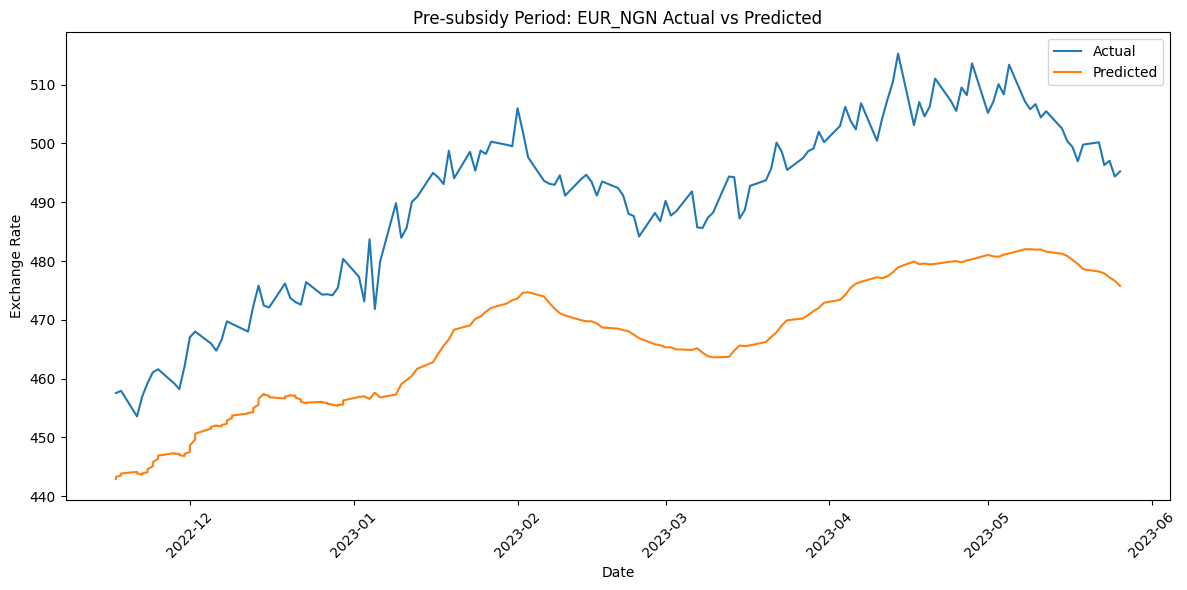

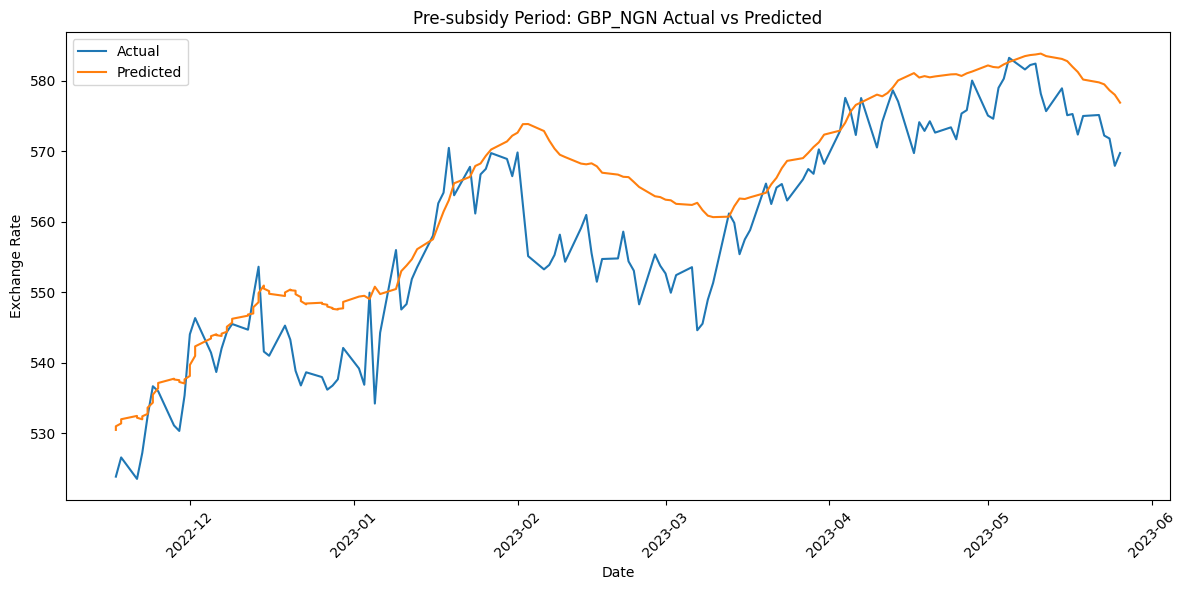


Generating plots for Post-subsidy Period...


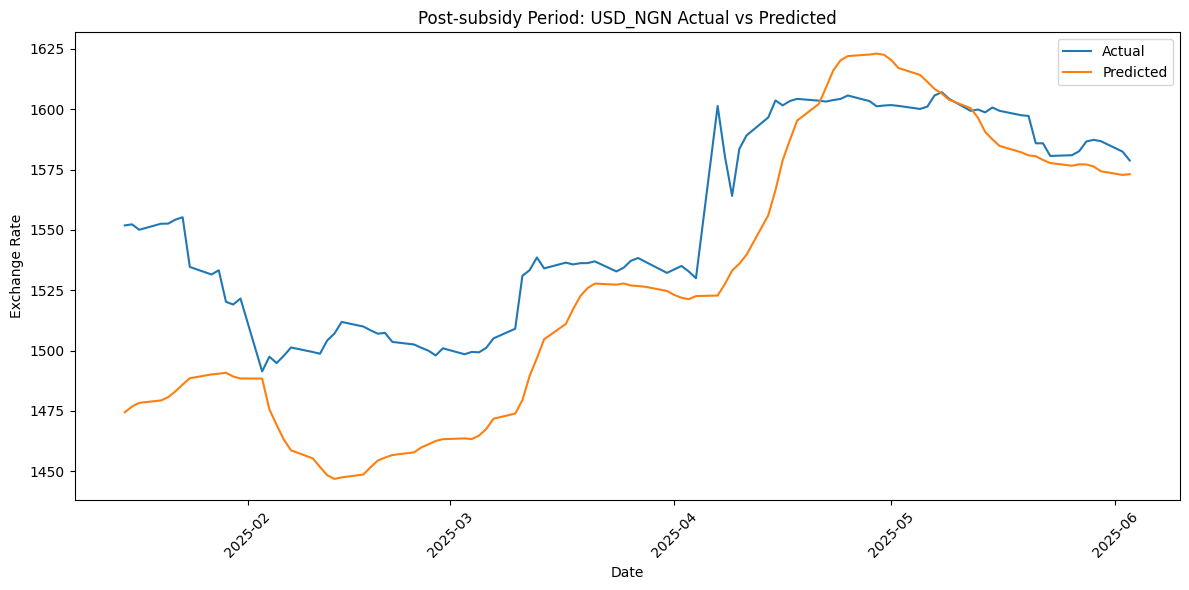

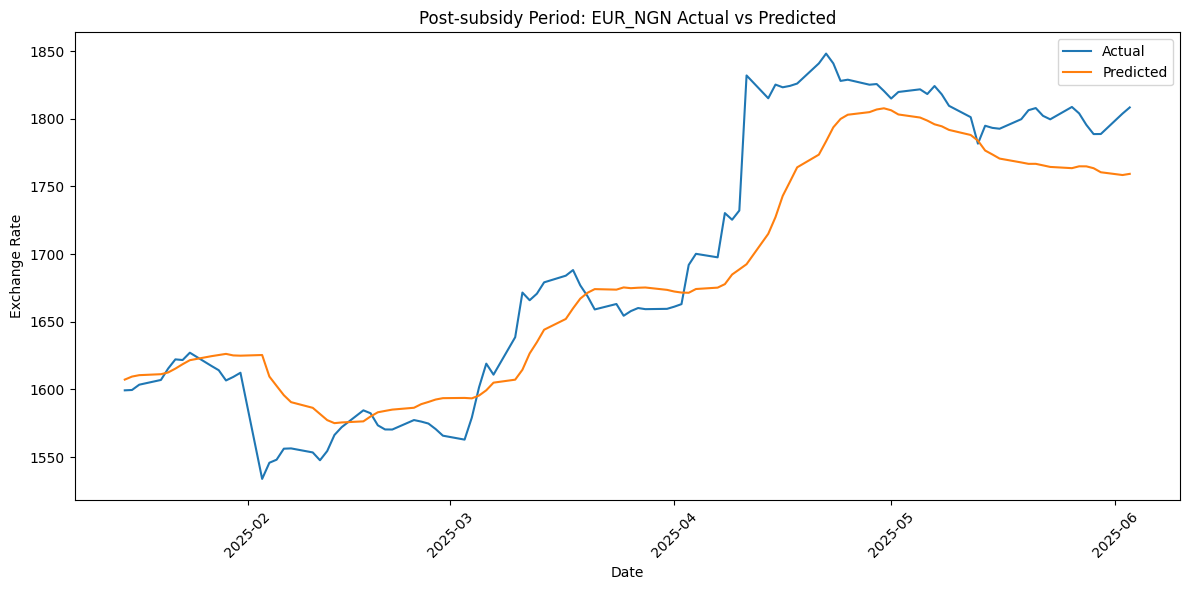

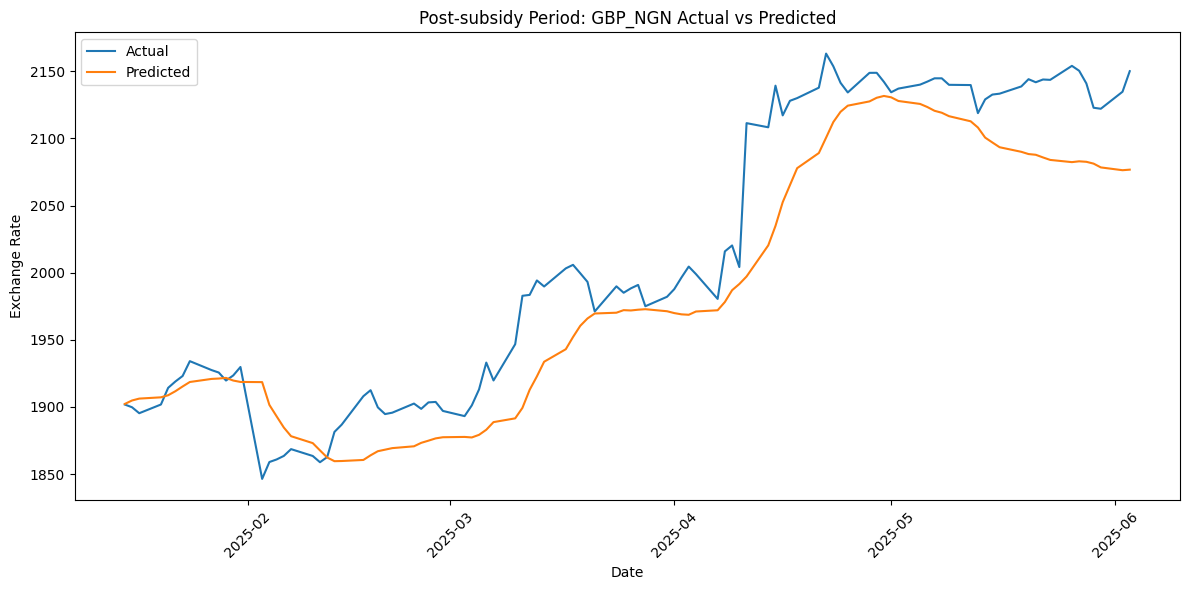


Generating combined pre and post plots...


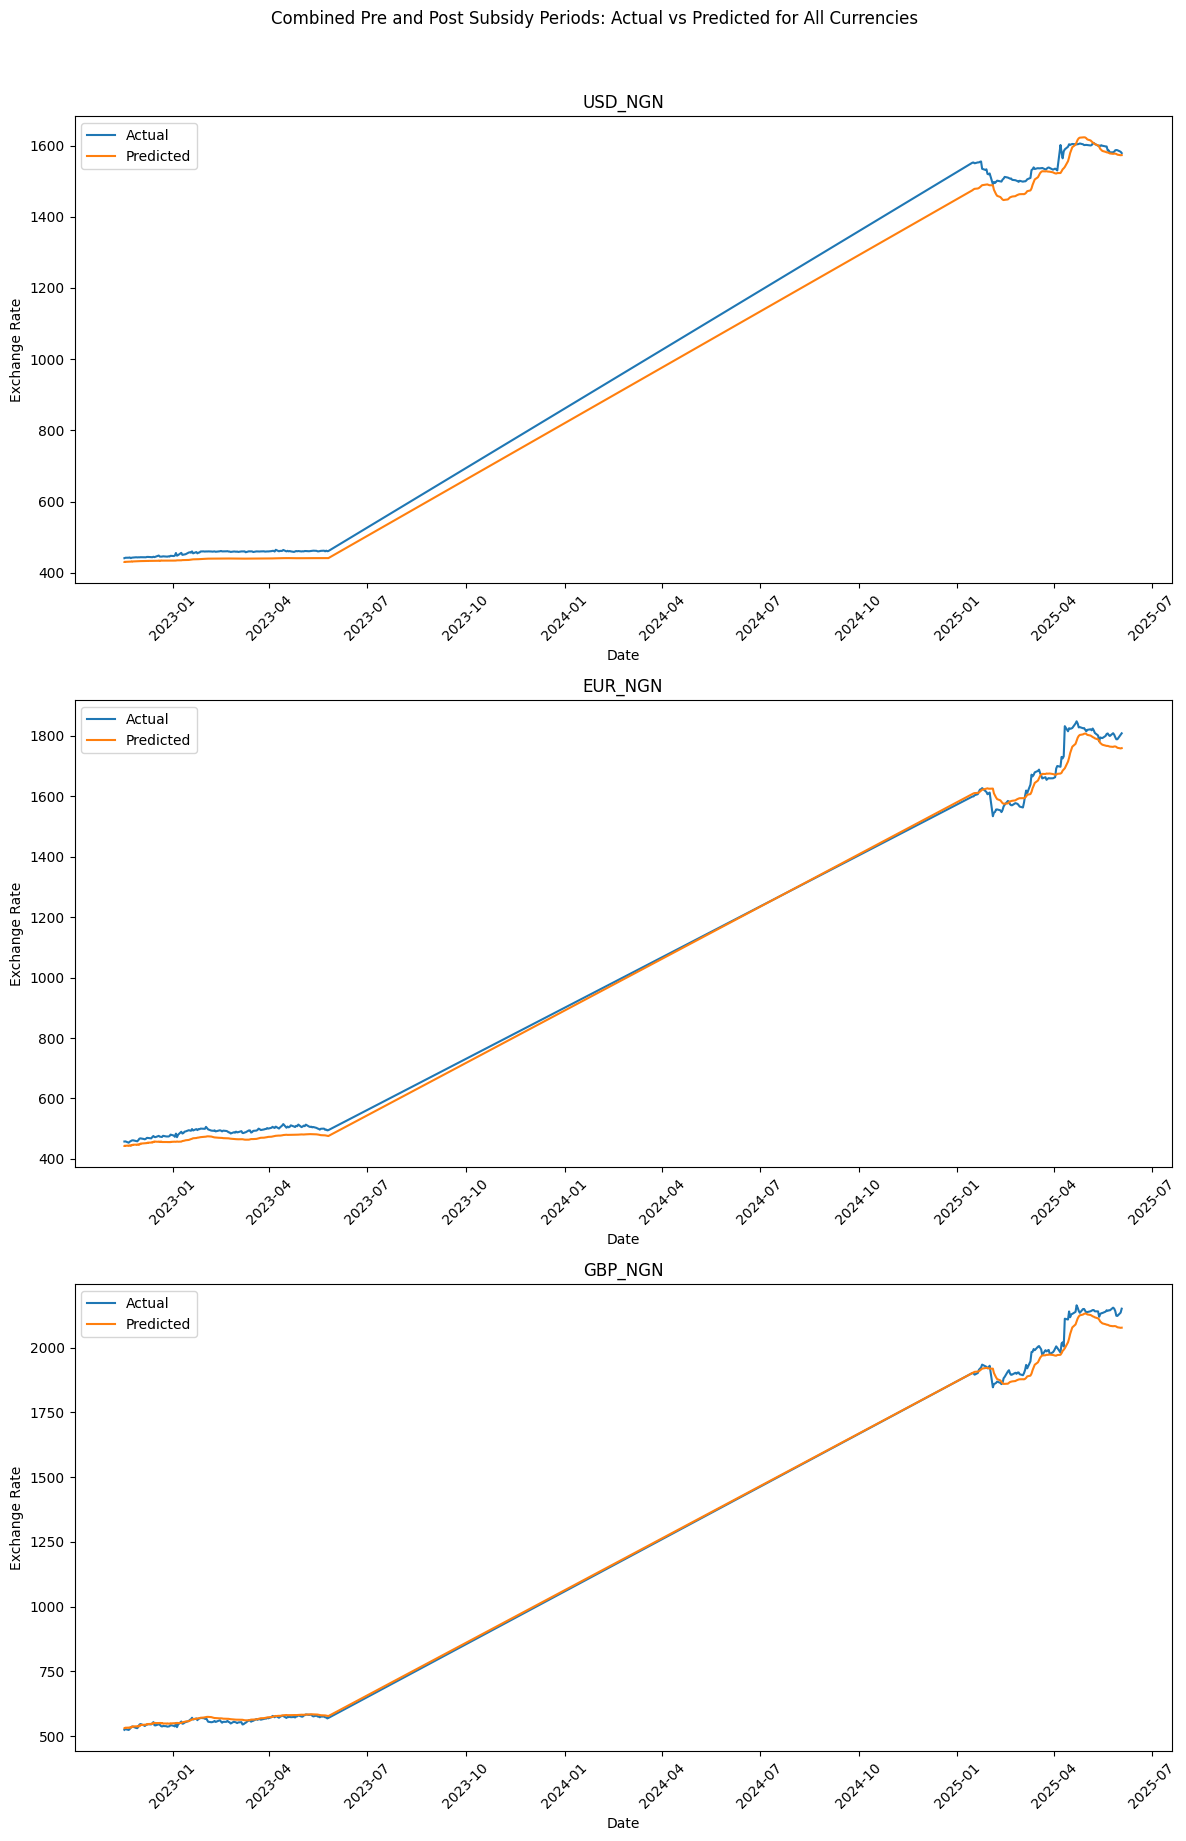


Generating RMSE and MAE bar plots (Pre vs Post-Subsidy)...


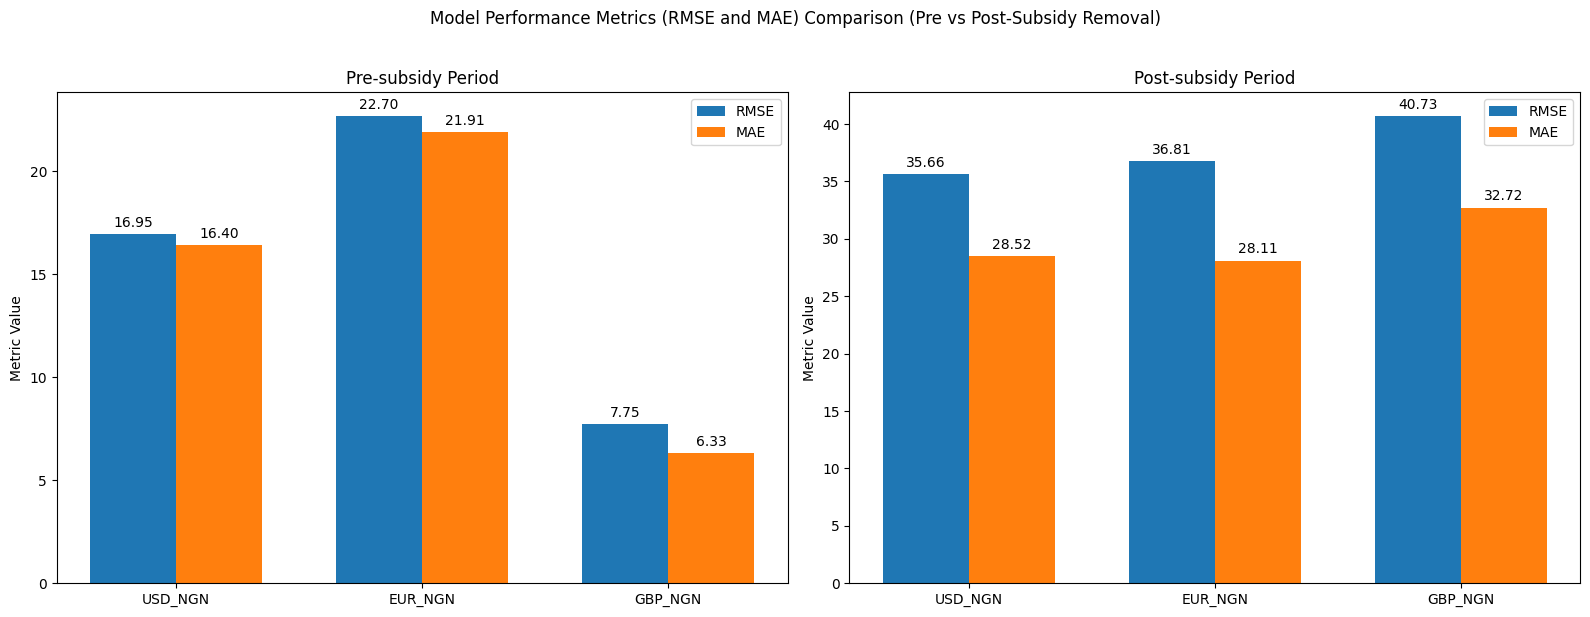


--- Plot Generation Complete ---


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# --- Set random seed for reproducibility ---
os.environ['PYTHONHASHSEED'] = '2'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(2)
np.random.seed(2)
tf.random.set_seed(2)

# --- Data Loading ---
file_path_normalized = 'normalized_data.csv'
file_path_original = 'merged_exchange_rates.csv'

if not os.path.exists(file_path_normalized):
    print(f"Error: File not found at {file_path_normalized}")
    raise FileNotFoundError(f"Required data file not found: {file_path_normalized}")

if not os.path.exists(file_path_original):
    print(f"Error: File not found at {file_path_original}")
    raise FileNotFoundError(f"Required data file not found: {file_path_original}")

try:
    normalized_df = pd.read_csv(file_path_normalized)
    original_df = pd.read_csv(file_path_original)
    print("Data loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    raise

# --- Data Preprocessing ---
if 'Unnamed: 4' in original_df.columns:
    original_df = original_df.drop('Unnamed: 4', axis=1)

normalized_df['Date'] = pd.to_datetime(normalized_df['Date'], format='%d/%m/%Y')
original_df['Date'] = pd.to_datetime(original_df['Date'], format='%d/%m/%Y')

features = ['USD_NGN_Norm', 'EUR_NGN_Norm', 'GBP_NGN_Norm']
original_currency_cols = ['USD_NGN', 'EUR_NGN', 'GBP_NGN']
normalized_currency_cols = ['USD_NGN_Norm', 'EUR_NGN_Norm', 'GBP_NGN_Norm']

# Define sequence length
sequence_length = 30

# Define a function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Function to denormalize predictions and true values and calculate metrics
def evaluate_denormalized(y_true_normalized, y_pred_normalized, original_df, currency_name):
    original_min = original_df[currency_name].min()
    original_max = original_df[currency_name].max()
    y_true_denormalized = y_true_normalized * (original_max - original_min) + original_min
    y_pred_denormalized = y_pred_normalized * (original_max - original_min) + original_min
    rmse_denormalized = np.sqrt(mean_squared_error(y_true_denormalized, y_pred_denormalized))
    mae_denormalized = mean_absolute_error(y_true_denormalized, y_pred_denormalized)
    return rmse_denormalized, mae_denormalized

# --- Define ConvLSTM Model Architecture ---
def build_convlstm_model(input_shape, output_units):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', input_shape=input_shape, return_sequences=False))
    model.add(Flatten())
    model.add(Dense(units=output_units, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# --- Define Periods ---
subsidy_removal_date = pd.to_datetime('2023-05-29')

full_df = normalized_df.copy()
pre_subsidy_df = normalized_df[normalized_df['Date'] < subsidy_removal_date].copy()
post_subsidy_df = normalized_df[normalized_df['Date'] >= subsidy_removal_date].copy()

periods = {
    'Full': full_df,
    'Pre-subsidy': pre_subsidy_df,
    'Post-subsidy': post_subsidy_df
}


# --- Calculate Performance Metrics and Store Predictions for Plotting ---

# Create dictionaries to store RMSE and MAE values and denormalized predictions/actuals for plotting
performance_metrics = {currency: {'RMSE': {}, 'MAE': {}} for currency in original_currency_cols}
all_period_predictions = {} # To store predictions and actuals for plotting

print("--- Calculating Performance Metrics and Preparing Plotting Data ---")
for period_name, period_df in periods.items():
    print(f"\nProcessing {period_name} Period...")

    if period_df.empty or len(period_df) <= sequence_length:
        print(f"Not enough data in {period_name} period.")
        continue

    data_for_sequences_period = period_df[features].values
    X_period, y_period = create_sequences(data_for_sequences_period, sequence_length)

    if len(X_period) == 0:
         print(f"Not enough data in {period_name} period to create sequences.")
         continue

    X_period = X_period.reshape((X_period.shape[0], sequence_length, 1, X_period.shape[2], 1))

    train_size_period = int(len(X_period) * 0.8)
    if train_size_period == 0 or train_size_period == len(X_period):
        print(f"Not enough data in {period_name} period for an 80/20 train/test split.")
        continue

    X_train_period, X_test_period = X_period[:train_size_period], X_period[train_size_period:]
    y_train_period, y_test_period = y_period[:train_size_period], y_period[train_size_period:]

    # Build and train a NEW model for this period
    print(f"Training model on {period_name} data...")
    model_period = build_convlstm_model(input_shape=(X_train_period.shape[1], X_train_period.shape[2], X_train_period.shape[3], X_train_period.shape[4]),
                                        output_units=y_train_period.shape[1])
    if X_train_period.shape[0] > 1 and X_train_period.shape[0] * 0.2 >= 1:
        history_period = model_period.fit(X_train_period, y_train_period, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
    else:
        history_period = model_period.fit(X_train_period, y_train_period, epochs=50, batch_size=32, verbose=0)

    print(f"Training on {period_name} data complete.")

    # Evaluate the trained model on the test set from the same period
    print(f"Evaluating model on {period_name} test set...")
    if len(X_test_period) > 0:
        y_pred_period = model_period.predict(X_test_period, verbose=0)

        # Get the corresponding dates for the test set
        test_dates_period = period_df['Date'].iloc[train_size_period + sequence_length:].reset_index(drop=True)

        # Store denormalized actual and predicted values for plotting and calculate metrics
        all_period_predictions[period_name] = {}
        print(f"\nDenormalized Performance Metrics for {period_name} Test Set:")
        for i, currency_norm in enumerate(normalized_currency_cols):
            currency_orig = original_currency_cols[i]
            y_test_currency_norm = y_test_period[:, i]
            y_pred_currency_norm = y_pred_period[:, i]

            # Evaluate denormalized using the original_df for the full range
            rmse_denorm, mae_denorm = evaluate_denormalized(
                y_test_currency_norm,
                y_pred_currency_norm,
                original_df,
                currency_orig
            )
            performance_metrics[currency_orig]['RMSE'][period_name] = rmse_denorm
            performance_metrics[currency_orig]['MAE'][period_name] = mae_denorm
            print(f'  {currency_orig}: RMSE={rmse_denorm:.4f}, MAE={mae_denorm:.4f}')

            # Store denormalized values and dates for plotting
            original_min = original_df[currency_orig].min()
            original_max = original_df[currency_orig].max()
            y_true_denormalized = y_test_currency_norm * (original_max - original_min) + original_min
            y_pred_denormalized = y_pred_currency_norm * (original_max - original_min) + original_min

            all_period_predictions[period_name][currency_orig] = {
                'dates': test_dates_period,
                'actual': y_true_denormalized,
                'predicted': y_pred_denormalized
            }

    else:
        print(f"No test data available for {period_name} evaluation or plotting.")

print("\n--- Performance Metrics Calculation and Data Preparation Complete ---")


# --- Generate and Display Plots ---
print("\n--- Generating Plots ---")

# Actual vs Predicted plots for each period and currency
for period_name in periods.keys():
    if period_name in all_period_predictions:
        print(f"\nGenerating plots for {period_name} Period...")
        for currency_orig in original_currency_cols:
            if currency_orig in all_period_predictions[period_name]:
                plot_data = all_period_predictions[period_name][currency_orig]
                plt.figure(figsize=(12, 6))
                plt.plot(plot_data['dates'], plot_data['actual'], label='Actual')
                plt.plot(plot_data['dates'], plot_data['predicted'], label='Predicted')
                plt.title(f'{period_name} Period: {currency_orig} Actual vs Predicted')
                plt.xlabel('Date')
                plt.ylabel('Exchange Rate')
                plt.legend()
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            else:
                print(f"No plot data available for {currency_orig} in {period_name} period.")
    else:
        print(f"No plot data available for {period_name} period.")


# Combined actual vs predicted plots for pre and post periods for each currency
print("\nGenerating combined pre and post plots...")
fig, axes = plt.subplots(nrows=len(original_currency_cols), ncols=1, figsize=(12, 18))
fig.suptitle('Combined Pre and Post Subsidy Periods: Actual vs Predicted for All Currencies', y=1.02)

for i, currency_orig in enumerate(original_currency_cols):
    combined_dates = []
    combined_actual = []
    combined_predicted = []

    if 'Pre-subsidy' in all_period_predictions and currency_orig in all_period_predictions['Pre-subsidy']:
        pre_plot_data = all_period_predictions['Pre-subsidy'][currency_orig]
        combined_dates.extend(pre_plot_data['dates'])
        combined_actual.extend(pre_plot_data['actual'])
        combined_predicted.extend(pre_plot_data['predicted'])

    if 'Post-subsidy' in all_period_predictions and currency_orig in all_period_predictions['Post-subsidy']:
        post_plot_data = all_period_predictions['Post-subsidy'][currency_orig]
        combined_dates.extend(post_plot_data['dates'])
        combined_actual.extend(post_plot_data['actual'])
        combined_predicted.extend(post_plot_data['predicted'])

    if combined_dates:
        sorted_indices = sorted(range(len(combined_dates)), key=lambda k: combined_dates[k])
        sorted_dates = [combined_dates[k] for k in sorted_indices]
        sorted_actual = [combined_actual[k] for k in sorted_indices]
        sorted_predicted = [combined_predicted[k] for k in sorted_indices]

        axes[i].plot(sorted_dates, sorted_actual, label='Actual')
        axes[i].plot(sorted_dates, sorted_predicted, label='Predicted')
        axes[i].set_title(f'{currency_orig}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Exchange Rate')
        axes[i].legend()
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Bar plots for RMSE and MAE (Pre vs Post-Subsidy)
print("\nGenerating RMSE and MAE bar plots (Pre vs Post-Subsidy)...")

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.suptitle('Model Performance Metrics (RMSE and MAE) Comparison (Pre vs Post-Subsidy Removal)', y=1.02)

metrics_to_plot = ['RMSE', 'MAE']
periods_to_compare = ['Pre-subsidy', 'Post-subsidy']
currency_labels = original_currency_cols
x = np.arange(len(currency_labels))
width = 0.35

# Plot for Pre-subsidy period
period_name = 'Pre-subsidy'
rmse_values = [performance_metrics[currency_orig]['RMSE'].get(period_name, 0) for currency_orig in original_currency_cols]
mae_values = [performance_metrics[currency_orig]['MAE'].get(period_name, 0) for currency_orig in original_currency_cols]

bars1 = axes[0].bar(x - width/2, rmse_values, width, label='RMSE')
bars2 = axes[0].bar(x + width/2, mae_values, width, label='MAE')

axes[0].set_ylabel('Metric Value')
axes[0].set_title(f'{period_name} Period')
axes[0].set_xticks(x)
axes[0].set_xticklabels(currency_labels)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=0) # Keep labels horizontal for clarity

# Add value labels on top of bars for Pre-subsidy
def autolabel(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1, axes[0])
autolabel(bars2, axes[0])


# Plot for Post-subsidy period
period_name = 'Post-subsidy'
rmse_values = [performance_metrics[currency_orig]['RMSE'].get(period_name, 0) for currency_orig in original_currency_cols]
mae_values = [performance_metrics[currency_orig]['MAE'].get(period_name, 0) for currency_orig in original_currency_cols]

bars1 = axes[1].bar(x - width/2, rmse_values, width, label='RMSE')
bars2 = axes[1].bar(x + width/2, mae_values, width, label='MAE')

axes[1].set_ylabel('Metric Value')
axes[1].set_title(f'{period_name} Period')
axes[1].set_xticks(x)
axes[1].set_xticklabels(currency_labels)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=0) # Keep labels horizontal for clarity

# Add value labels on top of bars for Post-subsidy
def autolabel(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1, axes[1])
autolabel(bars2, axes[1])


plt.tight_layout()
plt.show()


print("\n--- Plot Generation Complete ---")